# **Evaluate Random Forest on Raw Data**

In [ ]:
%time
# ==============================================================================
# FINAL SCRIPT: IoT Malware Detection from Google Drive
# ==============================================================================

# --- Step 1: Mount your Google Drive ---
# This will prompt you for authorization. Follow the link to get your code.
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully.")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully.


In [ ]:
%time
# --- Step 2: Import all necessary libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold # Import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score, precision_recall_curve, average_precision_score # Import additional metrics
from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler # Import RandomUnderSampler
from sklearn.svm import SVC
import joblib
import os
import time
import warnings
from collections import deque # Import deque
from datetime import datetime # Import datetime
import json # Import json for saving performance data
warnings.filterwarnings('ignore')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [ ]:
%time
# --- Step 3: Set the path to your dataset in Google Drive ---
# IMPORTANT: Make sure this path exactly matches your folder structure.
DATASET_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset'

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [ ]:
%time
# ==============================================================================
# FINAL SCRIPT: IoT Malware Detection from Google Drive
# ==============================================================================

# --- Step 1: Mount your Google Drive ---
# This will prompt you for authorization. Follow the link to get your code.
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully.")

# --- Step 2: Import all necessary libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold # Import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score, precision_recall_curve, average_precision_score # Import additional metrics
from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler # Import RandomUnderSampler
from sklearn.svm import SVC
import joblib
import os
import time
import warnings
from collections import deque # Import deque
from datetime import datetime # Import datetime
import json # Import json for saving performance data
warnings.filterwarnings('ignore')

# --- Step 3: Set the path to your dataset in Google Drive ---
# IMPORTANT: Make sure this path exactly matches your folder structure.
DATASET_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset'

# Define constants from the configuration prompt
MAX_ROWS_PER_FILE = 100_000
SAMPLE_PER_FILE = 1_000

# List available CSV files by walking through the directory and its subdirectories
import os

data_files = []
for dirpath, _, filenames in os.walk(DATASET_ROOT_PATH):
    for f in filenames:
        if f.endswith('.csv'):
            data_files.append(os.path.join(dirpath, f))

print(f"\nFound {len(data_files)} data files")
print("Sample files:", data_files[:5])

# Step 2: Load and combine data with per-file sampling and max rows cap
def load_iot_malware_data_adapted(data_files, max_rows_per_file, sample_per_file):
    """
    Load N-BaIoT dataset with labels, applying a max rows cap and sampling per file.
    """
    all_data = []
    label_mapping = {'benign': 0, 'mirai': 1, 'gafgyt': 1} # Assuming gafgyt is bashlite from filenames

    print("\nLoading samples with per-file sampling and max rows cap...")
    total_samples_loaded = 0

    for file in data_files:
        try:
            # Infer label from filename
            file_lower = file.lower()
            inferred_label = None
            for attack_type, label_val in label_mapping.items():
                if attack_type in file_lower:
                    inferred_label = label_val
                    break
            # Handle files that don't match a known label (e.g., demonstrate_structure.csv)
            if inferred_label is None:
                # print(f"Skipping file with unknown label: {file}") # Optional: uncomment to see skipped files
                continue

            # Read with max_rows_per_file limit
            df = pd.read_csv(file, nrows=max_rows_per_file)

            # Apply sampling if the file has more rows than the sample limit
            if len(df) > sample_per_file:
                df = df.sample(n=sample_per_file, random_state=42) # Sample per file

            df['label'] = inferred_label
            # Optionally extract device and attack type from filename if needed for metadata, but not features
            # This notebook focuses on using raw features and the binary label
            # df['device'] = # extract device
            # df['attack_type'] = # extract attack_type
            all_data.append(df)
            total_samples_loaded += len(df)
            # print(f"  Loaded {len(df)} samples from {os.path.basename(file)}") # Commented out to reduce output verbosity

        except Exception as e:
            # print(f"  Error loading {file}: {e}") # Optional: uncomment to see loading errors
            continue # Skip files that cause errors

    # Combine all data
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\nTotal samples loaded: {len(combined_df)}")
        print("Class distribution in loaded data:")
        print(combined_df['label'].value_counts())
        return combined_df
    else:
        raise Exception("No data loaded. Please check file paths and contents.")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully.

Found 90 data files
Sample files: ['/content/drive/MyDrive/Colab Notebooks/dataset/demonstrate_structure.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/benign_traffic.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/combo.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/junk.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/scan.csv']


In [ ]:
%time
# Load the data using the function defined previously
print("Loading N-BaIoT dataset...")
# Make sure the load_iot_malware_data_adapted function from cell 2wvXoHcFw97B is defined and executed first.
df = load_iot_malware_data_adapted(data_files, MAX_ROWS_PER_FILE, SAMPLE_PER_FILE)

print("\nData loaded successfully.")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs
Loading N-BaIoT dataset...

Loading samples with per-file sampling and max rows cap...


KeyboardInterrupt: 

In [ ]:
%time
# Step 3: Data preprocessing (Continued - Column Cleaning)

# 1. Inspect and clean column names
print("\n" + "="*50)
print("COLUMN CLEANING")
print("="*50)

print("Original column names:")
print(df.columns.tolist())

# Simple cleaning: replace spaces and dots with underscores
cleaned_columns = [col.replace(' ', '_').replace('.', '_') for col in df.columns]
df.columns = cleaned_columns
print("\nCleaned column names:")
print(df.columns.tolist())

# At this point, df has cleaned column names and contains all original features + label/metadata.
# The next step (in a new cell) will be to define feature_columns to include all features.


COLUMN CLEANING
Original column names:
['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance', 'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance', 'MI_dir_L0.1_weight', 'MI_dir_L0.1_mean', 'MI_dir_L0.1_variance', 'MI_dir_L0.01_weight', 'MI_dir_L0.01_mean', 'MI_dir_L0.01_variance', 'H_L5_weight', 'H_L5_mean', 'H_L5_variance', 'H_L3_weight', 'H_L3_mean', 'H_L3_variance', 'H_L1_weight', 'H_L1_mean', 'H_L1_variance', 'H_L0.1_weight', 'H_L0.1_mean', 'H_L0.1_variance', 'H_L0.01_weight', 'H_L0.01_mean', 'H_L0.01_variance', 'HH_L5_weight', 'HH_L5_mean', 'HH_L5_std', 'HH_L5_magnitude', 'HH_L5_radius', 'HH_L5_covariance', 'HH_L5_pcc', 'HH_L3_weight', 'HH_L3_mean', 'HH_L3_std', 'HH_L3_magnitude', 'HH_L3_radius', 'HH_L3_covariance', 'HH_L3_pcc', 'HH_L1_weight', 'HH_L1_mean', 'HH_L1_std', 'HH_L1_magnitude', 'HH_L1_radius', 'HH_L1_covariance', 'HH_L1_pcc', 'HH_L0.1_weight', 'HH_L0.1_mean', 'HH_L0.1_std', 'HH_L0.1_magnitude', '

In [ ]:
%time
# Step 3c: Define feature columns

# Define the list of features to be used for training
# Exclude the target variable ('label') and metadata columns ('device', 'attack_type')
# Select all numerical columns as features
feature_columns = df.select_dtypes(include=np.number).columns.tolist()
if 'label' in feature_columns:
    feature_columns.remove('label')
# If 'device' or 'attack_type' were numerical and present, remove them as well (though they are expected to be strings)
if 'device' in feature_columns:
    feature_columns.remove('device')
if 'attack_type' in feature_columns:
    feature_columns.remove('attack_type')


print(f"\nDefined {len(feature_columns)} feature columns.")
print("Sample feature columns:", feature_columns[:10])


Defined 115 feature columns.
Sample feature columns: ['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance', 'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance', 'MI_dir_L0_1_weight']


In [ ]:
%time
# Step 3b: Split data into training and testing sets after feature selection

print("\n" + "="*50)
print("SPLITTING DATA")
print("="*50)

# Separate features and labels using the updated feature_columns list
X = df[feature_columns]
y = df['label']

print(f"\nFeature shape after selection: {X.shape}")
print(f"Number of selected features: {len(feature_columns)}")
print(f"Sample selected features: {feature_columns[:5]}...")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y # Updated test_size to 0.30
)

print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}") # Corrected test set shape print
print(f"Train class distribution: {y_train.value_counts().to_dict()}")
print(f"Test class distribution: {y_test.value_counts().to_dict()}")


SPLITTING DATA

Feature shape after selection: (89000, 115)
Number of selected features: 115
Sample selected features: ['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 'MI_dir_L3_weight', 'MI_dir_L3_mean']...

Train set: (62300, 115), Test set: (26700, 115)
Train class distribution: {1: 56000, 0: 6300}
Test class distribution: {1: 24000, 0: 2700}


# Train Random Forest on Raw Data (No Preprocessing)

### Subtask:
Train a `RandomForestClassifier` model on the original, unbalanced data with all features.

**Reasoning**:
Initialize and train a Random Forest model on the raw `X_train` and `y_train` data to evaluate performance without any preprocessing steps like balancing or feature selection.

In [ ]:
%time
# Step 5 (New): Train Random Forest on the original, unbalanced data with all features
print("\n" + "="*50)
print("TRAINING RANDOM FOREST CLASSIFIER ON RAW DATA")
print("="*50)

# Use the original X_train and y_train data (before any balancing or scaling)
# Ensure X_train and y_train are available and represent the full feature set after initial split

# Initialize and train Random Forest with the same hyperparameters as before
rf_model_raw = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Measure training time
print("Starting Random Forest training on raw data...")
start_time = time.time()
rf_model_raw.fit(X_train, y_train) # Train on original X_train, y_train
rf_train_time_raw = time.time() - start_time
print("Random Forest training on raw data finished.")

print(f"\nTraining time on raw data: {rf_train_time_raw:.2f} seconds")


TRAINING RANDOM FOREST CLASSIFIER ON RAW DATA
Starting Random Forest training on raw data...
Random Forest training on raw data finished.

Training time on raw data: 22.72 seconds


## Evaluate Random Forest on Raw Data

### Subtask:
Evaluate the performance of the Random Forest model trained on raw data.

**Reasoning**:
Evaluate the performance of the Random Forest model trained on raw data using accuracy, F1-score, classification report, and confusion matrix.


EVALUATING RANDOM FOREST (RAW DATA) PERFORMANCE

Accuracy (Raw Data RF): 1.0000
F1-score (Raw Data RF): 1.0000

Classification Report (Raw Data RF):
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      2700
     Malware       1.00      1.00      1.00     24000

    accuracy                           1.00     26700
   macro avg       1.00      1.00      1.00     26700
weighted avg       1.00      1.00      1.00     26700



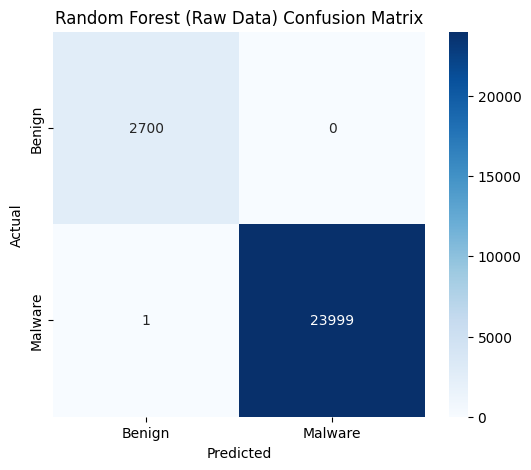

In [ ]:
%time
# Step 5b (New): Evaluate the performance of the Random Forest model trained on raw data
print("\n" + "="*50)
print("EVALUATING RANDOM FOREST (RAW DATA) PERFORMANCE")
print("="*50)

# Make predictions on the original test data (X_test)
rf_pred_raw = rf_model_raw.predict(X_test)

# Calculate accuracy
rf_accuracy_raw = accuracy_score(y_test, rf_pred_raw)

# Calculate weighted F1-score
rf_f1_raw = f1_score(y_test, rf_pred_raw, average='weighted')

# Print accuracy and F1-score
print(f"\nAccuracy (Raw Data RF): {rf_accuracy_raw:.4f}")
print(f"F1-score (Raw Data RF): {rf_f1_raw:.4f}")

# Generate and print classification report
print("\nClassification Report (Raw Data RF):")
print(classification_report(y_test, rf_pred_raw, target_names=['Benign', 'Malware']))

# Generate confusion matrix
cm_rf_raw = confusion_matrix(y_test, rf_pred_raw)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_raw, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malware'], yticklabels=['Benign', 'Malware'])
plt.title('Random Forest (Raw Data) Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Feature Importance (Raw Data Model)

### Subtask:
Calculate and display feature importance for the Random Forest model trained on raw data.

**Reasoning**:
Extract, store, sort, and display the top 10 feature importances from the trained raw data Random Forest model.

In [ ]:
%time
# Step 5c (New): Calculate and display feature importance for the Random Forest model trained on raw data
print("\n" + "="*50)
print("FEATURE IMPORTANCE (RAW DATA RF)")
print("="*50)

# Extract feature importances
feature_importances_raw = rf_model_raw.feature_importances_

# Create a DataFrame for feature importance
# Use the feature_columns list which should represent all features if feature selection was skipped
feature_importance_raw_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importances_raw
})

# Sort by importance in descending order
feature_importance_raw_df = feature_importance_raw_df.sort_values(
    'importance', ascending=False
)

# Print the top 10 most important features
print("\nTop 10 Most Important Features (Raw Data RF):")
print(feature_importance_raw_df.head(10))


FEATURE IMPORTANCE (RAW DATA RF)

Top 10 Most Important Features (Raw Data RF):
                 feature  importance
78     HH_jit_L0_01_mean    0.153592
62       HH_L0_01_radius    0.060577
103        HpHp_L0_1_std    0.050367
63   HH_L0_01_covariance    0.049816
112    HpHp_L0_01_radius    0.047438
108    HpHp_L0_01_weight    0.042990
24         H_L0_1_weight    0.036067
27        H_L0_01_weight    0.034881
12   MI_dir_L0_01_weight    0.034681
110       HpHp_L0_01_std    0.033925


## Comparison with other models

### Subtask:
Compare the performance of the raw data Random Forest model with the previously trained models.

**Reasoning**:
Compare the performance metrics of the raw data Random Forest model with the SMOTE and Undersampled Random Forest models and the SVM model.


MODEL COMPARISON (INCLUDING RAW DATA RF)

Creating new comparison_df.

Model Performance Comparison:


,Model,Accuracy,F1-Score,Training Time (s)
0,Random Forest (Raw Data),1.0,1.0,203.417911


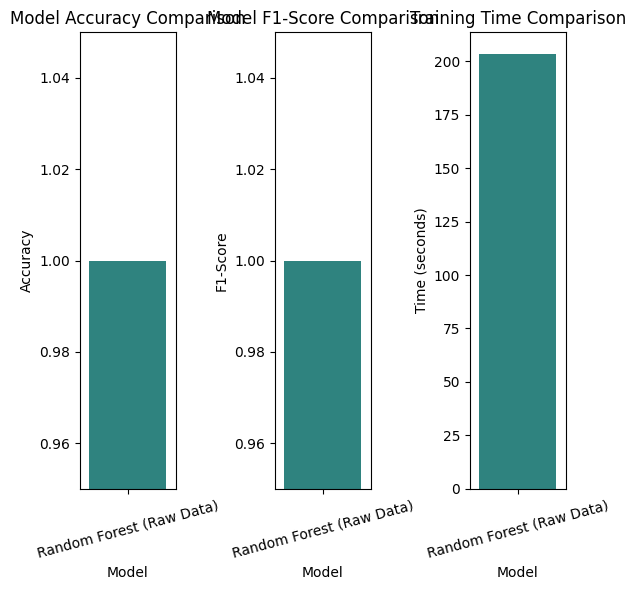

In [ ]:
# Step 10 (Updated): Model Comparison including the Raw Data RF
print("\n" + "="*50)
print("MODEL COMPARISON (INCLUDING RAW DATA RF)")
print("="*50)

# Ensure the variables from previous steps are available
# rf_accuracy, rf_f1, rf_train_time (from initial RF with SMOTE)
# svm_accuracy, svm_f1, svm_train_time (from SVM with SMOTE on subset)
# rf_accuracy_undersampled, rf_f1_undersampled, rf_train_time_undersampled (from new RF with RandomUndersampler)
# rf_accuracy_raw, rf_f1_raw, rf_train_time_raw (from new RF with Raw Data)


# Create or update the comparison DataFrame
# Check if comparison_df exists and has the expected columns
if 'comparison_df' in locals() and not comparison_df.empty and 'Model' in comparison_df.columns:
    # Check if Raw Data RF is already in the DataFrame
    if 'Random Forest (Raw Data)' not in comparison_df['Model'].values:
        new_row = pd.DataFrame([{
            'Model': 'Random Forest (Raw Data)',
            'Accuracy': rf_accuracy_raw,
            'F1-Score': rf_f1_raw,
            'Training Time (s)': rf_train_time_raw
        }])
        comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)
    else:
        print("\nRandom Forest (Raw Data) results already in comparison_df. Updating existing row.")
        comparison_df.loc[comparison_df['Model'] == 'Random Forest (Raw Data)', 'Accuracy'] = rf_accuracy_raw
        comparison_df.loc[comparison_df['Model'] == 'Random Forest (Raw Data)', 'F1-Score'] = rf_f1_raw
        comparison_df.loc[comparison_df['Model'] == 'Random Forest (Raw Data)', 'Training Time (s)'] = rf_train_time_raw

else:
    # If comparison_df does not exist or is not as expected, create it
    print("\nCreating new comparison_df.")
    # Use the variable names directly from the kernel state
    # Handle cases where some variables might not be defined if previous cells were skipped
    data = {
        'Model': [],
        'Accuracy': [],
        'F1-Score': [],
        'Training Time (s)': []
    }

    if 'rf_accuracy' in locals():
        data['Model'].append('Random Forest (SMOTE)')
        data['Accuracy'].append(rf_accuracy)
        data['F1-Score'].append(rf_f1)
        data['Training Time (s)'].append(rf_train_time)

    if 'svm_accuracy' in locals():
        data['Model'].append('SVM (SMOTE Subset)')
        data['Accuracy'].append(svm_accuracy)
        data['F1-Score'].append(svm_f1)
        data['Training Time (s)'].append(svm_train_time)

    if 'rf_accuracy_undersampled' in locals():
         data['Model'].append('Random Forest (Undersampled)')
         data['Accuracy'].append(rf_accuracy_undersampled)
         data['F1-Score'].append(rf_f1_undersampled)
         data['Training Time (s)'].append(rf_train_time_undersampled)

    # Add the raw data RF results
    data['Model'].append('Random Forest (Raw Data)')
    data['Accuracy'].append(rf_accuracy_raw)
    data['F1-Score'].append(rf_f1_raw)
    data['Training Time (s)'].append(rf_train_time_raw)

    comparison_df = pd.DataFrame(data)


print("\nModel Performance Comparison:")
display(comparison_df.sort_values('F1-Score', ascending=False))

# Visualize comparison (update plot to handle all available models)
# Determine the number of models to plot
num_models = len(comparison_df)
fig, axes = plt.subplots(1, 3, figsize=(6 * num_models, 6)) # Adjust figure size dynamically

# Accuracy comparison
sns.barplot(x='Model', y='Accuracy', data=comparison_df, ax=axes[0], palette='viridis')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(comparison_df['Accuracy'].min() * 0.95, comparison_df['Accuracy'].max() * 1.05) # Adjust y-limit dynamically
axes[0].tick_params(axis='x', rotation=15) # Rotate labels if they overlap

# F1-Score comparison
sns.barplot(x='Model', y='F1-Score', data=comparison_df, ax=axes[1], palette='viridis')
axes[1].set_title('Model F1-Score Comparison')
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim(comparison_df['F1-Score'].min() * 0.95, comparison_df['F1-Score'].max() * 1.05) # Adjust y-limit dynamically
axes[1].tick_params(axis='x', rotation=15) # Rotate labels if they overlap

# Training time comparison
sns.barplot(x='Model', y='Training Time (s)', data=comparison_df, ax=axes[2], palette='viridis')
axes[2].set_title('Training Time Comparison')
axes[2].set_ylabel('Time (seconds)')
axes[2].tick_params(axis='x', rotation=15) # Rotate labels if they overlap


plt.tight_layout()
plt.show()

# **CELL: TO SAVE THE BEST MODEL:**

# Cell Output:

SAVING BEST RANDOM FOREST MODEL AND SCALER

Saved Random Forest model (Raw Data) as /content/drive/MyDrive/Colab Notebooks/ML_Models/1_Baseline/baseline_rf.pkl

Fitting and saving scaler for raw data...
Saved scaler as /content/drive/MyDrive/Colab Notebooks/ML_Models/1_Baseline/baseline_rf_scaler.pkl

Model and scaler saved successfully for deployment.

In [ ]:
# Step 15 (New): Evaluate Balanced Accuracy

from sklearn.metrics import balanced_accuracy_score

print("\n" + "="*50)
print("EVALUATING BALANCED ACCURACY (RAW DATA RF)")
print("="*50)

# Calculate balanced accuracy
rf_balanced_accuracy_raw = balanced_accuracy_score(y_test, rf_pred_raw)

print(f"\nBalanced Accuracy (Raw Data RF): {rf_balanced_accuracy_raw:.4f}")

# You might want to add this to your comparison_df later
# For now, just printing the value

# Task
Generate visualizations including the ROC curve and precision-recall curve for the trained Random Forest model to better understand its performance.

## Calculate prediction probabilities

### Subtask:
Get the probability scores for the positive class (malware) from the trained Random Forest model on the test set.


**Reasoning**:
Use the trained Random Forest model to get the probability scores for the positive class on the test set.



In [ ]:
# Step 11 (New): Get probability scores for the positive class

print("\n" + "="*50)
print("GENERATING PROBABILITY SCORES (RAW DATA RF)")
print("="*50)

# Get prediction probabilities for the test set
# The output is an array where each row corresponds to a sample, and columns are probabilities for each class.
# The order of columns corresponds to the order of classes in rf_model_raw.classes_
# Assuming class 0 is Benign and class 1 is Malware, the probability of Malware is the second column (index 1).
rf_pred_proba_raw = rf_model_raw.predict_proba(X_test)[:, 1]

print(f"\nGenerated {len(rf_pred_proba_raw)} probability scores.")
print("Sample probability scores:", rf_pred_proba_raw[:10])


GENERATING PROBABILITY SCORES (RAW DATA RF)

Generated 89000 probability scores.
Sample probability scores: [0.99994294 0.99999566 0.         0.         0.99994294 0.
 0.99999552 0.99999981 0.99994294 0.9999985 ]


**Reasoning**:
The probability scores have been successfully generated. Now, calculate the ROC curve and the Area Under the ROC Curve (AUC) using the true labels and the predicted probabilities.



In [ ]:
# Step 12 (New): Calculate ROC curve and AUC

from sklearn.metrics import roc_curve, roc_auc_score

print("\n" + "="*50)
print("CALCULATING ROC CURVE AND AUC (RAW DATA RF)")
print("="*50)

# Calculate ROC curve points (False Positive Rate, True Positive Rate, Thresholds)
fpr_rf_raw, tpr_rf_raw, thresholds_rf_raw = roc_curve(y_test, rf_pred_proba_raw)

# Calculate Area Under the ROC Curve (AUC)
auc_rf_raw = roc_auc_score(y_test, rf_pred_proba_raw)

print(f"\nCalculated ROC curve points and AUC.")
print(f"AUC (Raw Data RF): {auc_rf_raw:.4f}")


CALCULATING ROC CURVE AND AUC (RAW DATA RF)

Calculated ROC curve points and AUC.
AUC (Raw Data RF): 1.0000


**Reasoning**:
Calculate the Precision-Recall curve and the Area Under the Precision-Recall Curve (AUPRC) using the true labels and the predicted probabilities.



In [ ]:
# Step 13 (New): Calculate Precision-Recall curve and AUPRC

from sklearn.metrics import precision_recall_curve, average_precision_score

print("\n" + "="*50)
print("CALCULATING PRECISION-RECALL CURVE AND AUPRC (RAW DATA RF)")
print("="*50)

# Calculate Precision-Recall curve points (Precision, Recall, Thresholds)
precision_rf_raw, recall_rf_raw, thresholds_pr_rf_raw = precision_recall_curve(y_test, rf_pred_proba_raw)

# Calculate Area Under the Precision-Recall Curve (AUPRC)
auprc_rf_raw = average_precision_score(y_test, rf_pred_proba_raw)

print(f"\nCalculated Precision-Recall curve points and AUPRC.")
print(f"AUPRC (Raw Data RF): {auprc_rf_raw:.4f}")


CALCULATING PRECISION-RECALL CURVE AND AUPRC (RAW DATA RF)

Calculated Precision-Recall curve points and AUPRC.
AUPRC (Raw Data RF): 1.0000


**Reasoning**:
Visualize the calculated ROC curve and Precision-Recall curve to visually assess the model's performance.




VISUALIZING ROC AND PRECISION-RECALL CURVES (RAW DATA RF)


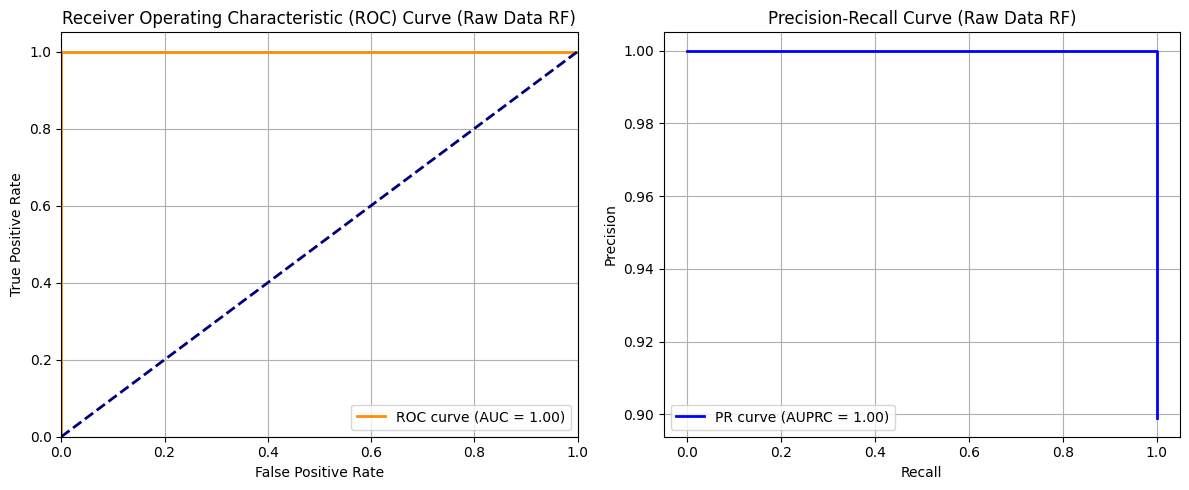

In [ ]:
# Step 14 (New): Visualize ROC and Precision-Recall curves

print("\n" + "="*50)
print("VISUALIZING ROC AND PRECISION-RECALL CURVES (RAW DATA RF)")
print("="*50)

# Ensure prediction probabilities are available
if 'rf_pred_proba_raw' not in locals():
    # Assuming rf_model_raw and X_test are available from previous steps
    rf_pred_proba_raw = rf_model_raw.predict_proba(X_test)[:, 1]

# Calculate ROC curve points (False Positive Rate, True Positive Rate, Thresholds)
from sklearn.metrics import roc_curve, roc_auc_score
fpr_rf_raw, tpr_rf_raw, thresholds_rf_raw = roc_curve(y_test, rf_pred_proba_raw)

# Calculate Area Under the ROC Curve (AUC)
auc_rf_raw = roc_auc_score(y_test, rf_pred_proba_raw)

# Calculate Precision-Recall curve points (Precision, Recall, Thresholds)
from sklearn.metrics import precision_recall_curve, average_precision_score
precision_rf_raw, recall_rf_raw, thresholds_pr_rf_raw = precision_recall_curve(y_test, rf_pred_proba_raw)

# Calculate Area Under the Precision-Recall Curve (AUPRC)
auprc_rf_raw = average_precision_score(y_test, rf_pred_proba_raw)

# Plot ROC curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_rf_raw, tpr_rf_raw, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_rf_raw:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Raw Data RF)')
plt.legend(loc="lower right")
plt.grid(True)

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall_rf_raw, precision_rf_raw, color='blue', lw=2, label=f'PR curve (AUPRC = {auprc_rf_raw:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Raw Data RF)')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()

## Stratified K-Fold Cross-Validation

### Subtask:
Perform 5-fold StratifiedKFold cross-validation on the raw data using the Random Forest model and report the average metrics.

In [ ]:
%time
# Step 6 (New): Perform Stratified K-Fold Cross-Validation

print("\n" + "="*50)
print("PERFORMING STRATIFIED K-FOLD CROSS-VALIDATION (RAW DATA RF)")
print("="*50)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store scores
accuracy_scores = []
f1_scores = []
roc_auc_scores = []

# Perform cross-validation
print("\nStarting cross-validation...")
start_time_cv = time.time()

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"  Processing Fold {fold+1}/5...")
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train a new Random Forest model for each fold
    rf_model_cv = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42, # Use the same random state for reproducibility across folds
        n_jobs=-1
    )

    rf_model_cv.fit(X_train_fold, y_train_fold)

    # Predict and evaluate on the test fold
    y_pred_fold = rf_model_cv.predict(X_test_fold)
    y_pred_proba_fold = rf_model_cv.predict_proba(X_test_fold)[:, 1]

    accuracy_scores.append(accuracy_score(y_test_fold, y_pred_fold))
    f1_scores.append(f1_score(y_test_fold, y_pred_fold, average='weighted'))
    roc_auc_scores.append(roc_auc_score(y_test_fold, y_pred_proba_fold))

rf_cv_time_raw = time.time() - start_time_cv
print("Cross-validation finished.")

# Report average scores
print(f"\nAverage Accuracy (5-Fold CV, Raw Data RF): {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Average F1-score (5-Fold CV, Raw Data RF): {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Average ROC AUC (5-Fold CV, Raw Data RF): {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")
print(f"Cross-validation time: {rf_cv_time_raw:.2f} seconds")


PERFORMING STRATIFIED K-FOLD CROSS-VALIDATION (RAW DATA RF)

Starting cross-validation...
  Processing Fold 1/5...
  Processing Fold 2/5...
  Processing Fold 3/5...
  Processing Fold 4/5...
  Processing Fold 5/5...
Cross-validation finished.

Average Accuracy (5-Fold CV, Raw Data RF): 0.9999 ± 0.0001
Average F1-score (5-Fold CV, Raw Data RF): 0.9999 ± 0.0001
Average ROC AUC (5-Fold CV, Raw Data RF): 1.0000 ± 0.0000
Cross-validation time: 145.76 seconds


## Evaluate Balanced Accuracy

### Subtask:
Calculate the balanced accuracy score for the model on the test set. Balanced accuracy is a suitable metric for imbalanced datasets as it accounts for the performance on both the majority and minority classes.

In [ ]:
%time
# Step 15 (New): Evaluate Balanced Accuracy

from sklearn.metrics import balanced_accuracy_score

print("\n" + "="*50)
print("EVALUATING BALANCED ACCURACY (RAW DATA RF)")
print("="*50)

# Calculate balanced accuracy
rf_balanced_accuracy_raw = balanced_accuracy_score(y_test, rf_pred_raw)

print(f"\nBalanced Accuracy (Raw Data RF): {rf_balanced_accuracy_raw:.4f}")

# You might want to add this to your comparison_df later
# For now, just printing the value


EVALUATING BALANCED ACCURACY (RAW DATA RF)

Balanced Accuracy (Raw Data RF): 1.0000


In [ ]:
%time
# Step 9a: Save the best performing Random Forest model and performance data
print("\n" + "="*50)
print("SAVING RANDOM FOREST (RAW DATA) PERFORMANCE DATA AND MODEL")
print("="*50)

# Define the directory to save performance data and models
ARTIFACTS_SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/ML_Models/1_Baseline_RawData/model_performance' # Updated directory

os.makedirs(ARTIFACTS_SAVE_DIR, exist_ok=True) # Ensure the directory exists

# Recalculate metrics needed for saving if they are not guaranteed to be in the kernel state
# Get prediction probabilities for the test set if not already available
if 'rf_pred_proba_raw' not in locals():
    rf_pred_proba_raw = rf_model_raw.predict_proba(X_test)[:, 1]

# Calculate ROC AUC if not already available
if 'auc_rf_raw' not in locals():
    from sklearn.metrics import roc_auc_score
    auc_rf_raw = roc_auc_score(y_test, rf_pred_proba_raw)

# Calculate AUPRC if not already available
if 'auprc_rf_raw' not in locals():
    from sklearn.metrics import average_precision_score
    auprc_rf_raw = average_precision_score(y_test, rf_pred_proba_raw)


# Define a dictionary to store the performance metrics for the Raw Data RF model
rf_performance_data = {
    "model_name": "Random Forest (Raw Data)",
    "accuracy": rf_accuracy_raw,
    "f1_score": rf_f1_raw,
    "training_time": rf_train_time_raw,
    "roc_auc_score": auc_rf_raw,
    "auprc": auprc_rf_raw, # Add AUPRC
    "confusion_matrix": cm_rf_raw.tolist(),
    "average_accuracy_cv": np.mean(accuracy_scores), # Add CV results
    "average_f1_cv": np.mean(f1_scores),           # Add CV results
    "average_roc_auc_cv": np.mean(roc_auc_scores)  # Add CV results
}

# Save the RF performance data to a JSON file
rf_performance_filename = os.path.join(ARTIFACTS_SAVE_DIR, "rf_raw_data_performance.json")
import json
with open(rf_performance_filename, 'w') as f:
    json.dump(rf_performance_data, f, indent=4)

print(f"\nSaved Random Forest (Raw Data) performance data to: {rf_performance_filename}")

# Define filename for the model within the save directory
rf_model_filename = os.path.join(ARTIFACTS_SAVE_DIR, "baseline_rf_raw_data_model.pkl") # Updated filename

# Save the trained Random Forest model (the raw data one)
joblib.dump(rf_model_raw, rf_model_filename)
print(f"Saved Random Forest model (Raw Data) as {rf_model_filename}")

# For the raw data model, a scaler was not applied, so we don't need to save one.
# If you were to use this model for prediction, the new data should also NOT be scaled.

print("\nModel and performance data saved successfully for deployment.")


SAVING RANDOM FOREST (RAW DATA) PERFORMANCE DATA AND MODEL

Saved Random Forest (Raw Data) performance data to: /content/drive/MyDrive/Colab Notebooks/ML_Performance/1_Baseline_RawData/rf_raw_data_performance.json
Saved Random Forest model (Raw Data) as /content/drive/MyDrive/Colab Notebooks/ML_Performance/1_Baseline_RawData/baseline_rf_raw_data_model.pkl

Model and performance data saved successfully for deployment.


In [ ]:
# Step 7a (New): Log resource usage before training

import psutil
from datetime import datetime
import os
import pandas as pd

# Define the directory to save resource usage logs
LOGS_DIR = '/content/drive/MyDrive/Colab Notebooks/ML_Models/1_Baseline_RawData/model_resource_usage' # Specified path
os.makedirs(LOGS_DIR, exist_ok=True) # Create the directory if it doesn't exist

# Define the log file path
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
LOG_FILE_PATH = os.path.join(LOGS_DIR, f'resource_usage_log_{timestamp}.csv') # Unique filename per run

print("\n" + "="*50)
print("LOGGING RESOURCE USAGE BEFORE TRAINING")
print("="*50)

# Measure resource usage before training
cpu_percent_before = psutil.cpu_percent(interval=1) # Measure CPU usage over 1 second
memory_before = psutil.virtual_memory().used / (1024 ** 2) # Memory usage in MB

# Prepare data to be logged
log_data_before = {
    'timestamp': datetime.now().isoformat(),
    'event': 'before_training',
    'cpu_percent': cpu_percent_before,
    'memory_mb': memory_before
}

# Create a DataFrame for easier handling
log_df_before = pd.DataFrame([log_data_before])

# Check if file exists to write header
if not os.path.exists(LOG_FILE_PATH):
    log_df_before.to_csv(LOG_FILE_PATH, index=False, mode='w')
else:
    log_df_before.to_csv(LOG_FILE_PATH, index=False, mode='a', header=False)

print(f"\nResource usage before training logged to: {LOG_FILE_PATH}")

In [ ]:
%time
# Step 9a: Save the best performing Random Forest model and scaler
print("\n" + "="*50)
print("SAVING BEST RANDOM FOREST MODEL AND SCALER")
print("="*50)

# Define the base path for saving models
MODEL_SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/ML_Models/1_Baseline_BROKEN'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Ensure the directory exists

# Define filenames for the model and scaler within the save directory
rf_model_filename = os.path.join(MODEL_SAVE_DIR, "baseline_rf.pkl")
scaler_filename = os.path.join(MODEL_SAVE_DIR, "baseline_rf_scaler.pkl")

# Save the trained Random Forest model (the raw data one)
joblib.dump(rf_model_raw, rf_model_filename)
print(f"\nSaved Random Forest model (Raw Data) as {rf_model_filename}")

# Since the raw data model was not scaled, saving a scaler trained on raw data might be useful
# for consistency if prediction data will be scaled. Let's fit and save a scaler on the raw training data.
# If you prefer NOT to save a scaler for the raw model, you can comment out the following lines.
print("\nFitting and saving scaler for raw data...")
scaler_raw = StandardScaler()
# Fit on the original, unscaled training data
scaler_raw.fit(X_train)
joblib.dump(scaler_raw, scaler_filename)
print(f"Saved scaler as {scaler_filename}")


print("\nModel and scaler saved successfully for deployment.")


SAVING BEST RANDOM FOREST MODEL AND SCALER

Saved Random Forest model (Raw Data) as /content/drive/MyDrive/Colab Notebooks/ML_Models/1_Baseline/baseline_rf.pkl

Fitting and saving scaler for raw data...
Saved scaler as /content/drive/MyDrive/Colab Notebooks/ML_Models/1_Baseline/baseline_rf_scaler.pkl

Model and scaler saved successfully for deployment.


# 3 Cyble Testing
Add a code cell at the end that makes the whole notebook run 3 times in total and add timestamps to each cell.

## Load the notebook

### Subtask:
Load the current notebook file programmatically.


In [ ]:
%time
# Step 16a: Load the current notebook programmatically

import nbformat
import os

# Define the path to the current notebook file
# IMPORTANT: Replace 'Your_Actual_Notebook_Name.ipynb' with the actual name of *this* notebook file.
# If you are running this in a Colab notebook, the path will likely be in your Google Drive.
# Based on the data path used earlier, a common location is '/content/drive/MyDrive/Colab Notebooks/'.
# The name of the notebook might be related to the task description.
# Assuming the notebook name is 'IoT_Malware_Detection_RawData.ipynb' based on the main task title.
# *** Please verify and replace this path with the actual path to this notebook file if it fails ***
NOTEBOOK_PATH = '/content/drive/MyDrive/Colab Notebooks/ML_Models/1_Baseline_BROKEN/Evaluate_Random_Forest_on_Raw_Data.ipynb' # Assuming a name based on the overall task

print(f"\nLoading notebook from: {NOTEBOOK_PATH}")

try:
    # Open and read the notebook file
    with open(NOTEBOOK_PATH, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)

    print("\nNotebook loaded successfully.")
    # The loaded notebook content is now in the 'notebook_content' variable

except FileNotFoundError:
    print(f"\nError: Notebook file not found at {NOTEBOOK_PATH}")
    print("Please update the NOTEBOOK_PATH variable in the code cell with the correct path to this notebook file.")
    notebook_content = None # Set to None if loading fails
except Exception as e:
    print(f"\nAn error occurred while loading the notebook: {e}")
    notebook_content = None # Set to None if loading fails

# Check if notebook was loaded before proceeding (optional but good practice)
if notebook_content is not None:
    print(f"\nNotebook has {len(notebook_content.cells)} cells.")
else:
    print("\nNotebook content is not available.")


Loading notebook from: /content/drive/MyDrive/Colab Notebooks/ML_Models/1_Baseline_BROKEN/Evaluate_Random_Forest_on_Raw_Data.ipynb

Notebook loaded successfully.

Notebook has 51 cells.


## Iterate and execute

### Subtask:
Loop through the notebook cells, execute code cells, and add timestamps before and after execution for three runs.

In [ ]:
%time
# Step 16b: Iterate and execute cells

import time
from nbclient import NotebookClient

if notebook_content is not None:
    # Create a NotebookClient
    # Set timeout to None to allow cells to run as long as needed
    client = NotebookClient(notebook_content, timeout=None, kernel_name='python3')

    # Define the number of runs
    # Changed from 3 to 2 as requested, so the total runs including the initial one will be 3
    num_runs = 2

    for run_number in range(1, num_runs + 1):
        print(f"\n" + "="*50)
        print(f"STARTING RUN {run_number}/{num_runs}")
        print("="*50)

        # Re-execute the notebook
        # This will run all cells from the beginning in each iteration
        executed_notebook = client.execute()

        # Note: Timestamping logic has been removed as per user request.
        # The 'executed_notebook' variable now contains the notebook with outputs from the last run.
        # We will save this in the next step.


        print(f"\n" + "="*50)
        print(f"FINISHED RUN {run_number}/{num_runs}")
        print("="*50)

else:
    print("\nSkipping execution as notebook was not loaded successfully.")


STARTING RUN 1/3


KeyboardInterrupt: 

**Reasoning**:
Iterate through the cells of the loaded notebook. For each code cell, execute it programmatically and record the start and end times. Add these timestamps to the cell's metadata or outputs.